# 0. Setup

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# 1. Load Data

In [2]:
# TRAIN_FILE_PATH = '/content/drive/My Drive/market_approvability_train.csv'
# TEST_FILE_PATH = '/content/drive/MyDrive/market_approvability_test.csv'

TRAIN_FILE_PATH = 'market_approvability_train.csv'
TEST_FILE_PATH = 'market_approvability_test.csv'

In [3]:

import re
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler



# TRAIN_FILE_PATH = '/content/drive/My Drive/market_approvability_train.csv'
# TEST_FILE_PATH = '/content/drive/MyDrive/market_approvability_test.csv'

TRAIN_FILE_PATH = 'market_approvability_train.csv'
TEST_FILE_PATH = 'market_approvability_test.csv'

df_train = pd.read_csv(TRAIN_FILE_PATH, usecols=['smiles', 'label'])
smiles_train = df_train['smiles'].to_numpy()
labels_train = df_train['label'].to_numpy()
df_test = pd.read_csv(TEST_FILE_PATH, usecols=['smiles', 'label'])
smiles_test = df_test['smiles'].to_numpy()
labels_test = df_test['label'].to_numpy()

print(f"Loaded {len(smiles_train)} training SMILES, {len(smiles_test)} test SMILES.")

Loaded 8447 training SMILES, 939 test SMILES.


# 2. Tokenization

In [4]:
def tokenize_smiles(smiles, exclusive_tokens=None):
      """
      Tokenize a SMILES molecule at atom-level:
          (1) 'Br' and 'Cl' are two-character tokens
          (2) Symbols with bracket are considered as tokens

      exclusive_tokens: A list of specifical symbols with bracket you want to keep. e.g., ['[C@@H]', '[nH]'].
      Other symbols with bracket will be replaced by '[UNK]'. default is `None`.
      """

      pattern = "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"

      regex = re.compile(pattern)
      tokens = [token for token in regex.findall(smiles)]

      if exclusive_tokens:
          for i, tok in enumerate(tokens):
              if tok.startswith('['):
                  if tok not in exclusive_tokens:
                      tokens[i] = '[UNK]'

      return tokens

<>:11: SyntaxWarning: invalid escape sequence '\['
<>:11: SyntaxWarning: invalid escape sequence '\['
C:\Users\berna\AppData\Local\Temp\ipykernel_44568\1511476010.py:11: SyntaxWarning: invalid escape sequence '\['
  pattern = "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"


In [5]:
# Tokenize train/test sets
tokenized_train = [tokenize_smiles(s) for s in smiles_train]
tokenized_test  = [tokenize_smiles(s) for s in smiles_test]

# 3. Build Vocabulary

In [6]:
def build_vocab(tokenized_data):
    """
    Takes a list of token lists and builds:
      - token_to_idx: dict mapping token -> int
      - idx_to_token: dict mapping int -> token
    """
    token_freq = defaultdict(int)
    # print(token_freq)

    # Count frequencies across all SMILES
    for tokens in tokenized_data:
        for t in tokens:
            token_freq[t] += 1
    # print(token_freq)

    # Sort tokens by descending frequency
    sorted_tokens = sorted(token_freq.keys(), key=lambda x: -token_freq[x])

    token_to_idx = {}
    idx_to_token = {}

    for i, token in enumerate(sorted_tokens):
        token_to_idx[token] = i
        idx_to_token[i] = token

    return token_to_idx, idx_to_token

In [7]:
# Build vocab from the TRAIN set only
token_to_idx, idx_to_token = build_vocab(tokenized_train)
vocab_size = len(token_to_idx)

print(f"Vocab size = {vocab_size}")

Vocab size = 51


In [8]:
print(token_to_idx)

{'C': 0, 'c': 1, '(': 2, ')': 3, 'O': 4, '1': 5, '=': 6, '2': 7, 'N': 8, '[C@@H]': 9, '[C@H]': 10, '[n]': 11, '3': 12, '/': 13, 'F': 14, '4': 15, 'S': 16, '[C@]': 17, 'Cl': 18, '[C@@]': 19, '-': 20, '[nH]': 21, '\\': 22, '5': 23, '[N+]': 24, 'o': 25, '#': 26, '[s]': 27, '[O-]': 28, 'I': 29, 'P': 30, ':': 31, 'Br': 32, '[P@@]': 33, '[n+]': 34, '6': 35, '[P@]': 36, '[S@]': 37, '[S@@]': 38, '7': 39, '[N@@+]': 40, '8': 41, '[N@+]': 42, '0': 43, '9': 44, '[N-]': 45, '[S@@+]': 46, '[S@+]': 47, '[C-]': 48, '[s+]': 49, '[S+]': 50}


# 4. Create SKIP-GRAM Pairs

In [9]:
def generate_skipgram_pairs(tokenized_data, token_to_idx, window_size=2):
    """
    Creates (target, context) pairs for skip-gram training.
    For each token in a SMILES, we take 'window_size' tokens to the left
    and right as its context (if they exist).
    """
    pairs = []

    for tokens in tokenized_data:
        indices = [token_to_idx[t] for t in tokens if t in token_to_idx]
        for i, target_idx in enumerate(indices):
            # Identify context positions
            start = max(0, i - window_size)
            end   = min(len(indices), i + window_size + 1)

            for j in range(start, end):
                if j != i:
                    context_idx = indices[j]
                    pairs.append((target_idx, context_idx))

    return pairs

In [10]:
skipgram_pairs_train = generate_skipgram_pairs(tokenized_train, token_to_idx, window_size=2)
print(f"Number of (target, context) pairs in training set: {len(skipgram_pairs_train)}")

Number of (target, context) pairs in training set: 1507242


# 5. Define SKIP-GRAM Model (with Negative Sampling)

In [11]:
class SkipGramNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        """
        We maintain two embeddings:
          - embedding_v: for 'target' words
          - embedding_u: for 'context' words
        """
        super(SkipGramNegativeSampling, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.embedding_v = nn.Embedding(vocab_size, embedding_dim)  # target embedding
        self.embedding_u = nn.Embedding(vocab_size, embedding_dim)  # context embedding

        nn.init.xavier_uniform_(self.embedding_v.weight)
        nn.init.xavier_uniform_(self.embedding_u.weight)

    def forward(self, target_idxs, context_idxs, negative_idxs):
        """
        Inputs:
          target_idxs: (batch_size)
          context_idxs: (batch_size)
          negative_idxs: (batch_size, K) => K negative samples per target
        Returns:
          pos_score: (batch_size)   => dot(target, context)
          neg_score: (batch_size,K) => dot(target, negative_k)
        """
        # Retrieve embeddings for targets and contexts
        v = self.embedding_v(target_idxs)       # (batch_size, embed_dim)
        u = self.embedding_u(context_idxs)      # (batch_size, embed_dim)

        # Positive score
        pos_score = torch.sum(v * u, dim=1)     # dot product row-wise => (batch_size)

        # Negative embeddings => shape (batch_size, K, embed_dim)
        neg_u = self.embedding_u(negative_idxs)

        # Expand v for broadcasting => (batch_size, 1, embed_dim)
        v = v.unsqueeze(1)
        # Dot with each negative embedding => (batch_size, K)
        neg_score = torch.sum(v * neg_u, dim=2)

        return pos_score, neg_score

In [12]:
def negative_sampling_loss(pos_score, neg_score):
    """
    Negative sampling loss:
      - Maximize log(sigmoid(pos_score))
      - Maximize log(sigmoid(-neg_score)) for negative samples
    """
    # pos_score: (batch_size)
    # neg_score: (batch_size, K)

    # Avoid log(0)
    eps = 1e-9

    # Positive part: log(sigmoid(pos_score))
    pos_loss = -torch.log(torch.sigmoid(pos_score) + eps)

    # Negative part: sum of log(sigmoid(-neg_score)) over K negative samples
    neg_loss = -torch.sum(torch.log(torch.sigmoid(-neg_score) + eps), dim=1)

    return torch.mean(pos_loss + neg_loss)

# 6. Training The Model

 ****************************  SkipGram model with embedding_dim = 50 **********************
Starting Skip-Gram training...


Epoch 1/5 completed. Avg Loss: 1.4534


Epoch 2/5 completed. Avg Loss: 1.4462


Epoch 3/5 completed. Avg Loss: 1.4460


Epoch 4/5 completed. Avg Loss: 1.4459


Epoch 5/5 completed. Avg Loss: 1.4467

Training complete. Total time: 410.72s for 5 epochs.


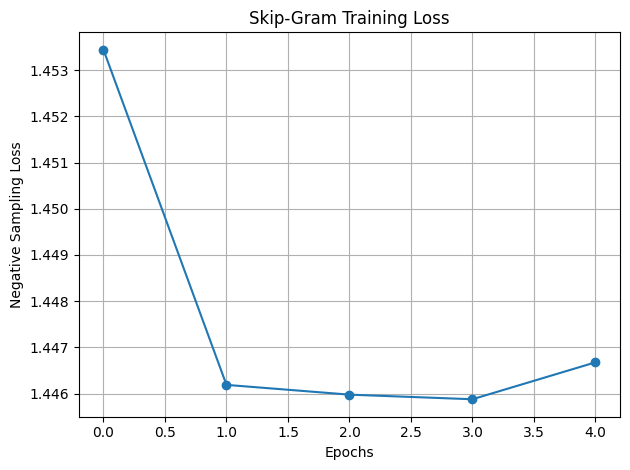

 ****************************  SkipGram model with embedding_dim = 100 **********************
Starting Skip-Gram training...


Epoch 1/5 completed. Avg Loss: 1.4574


Epoch 2/5 completed. Avg Loss: 1.4490


Epoch 3/5 completed. Avg Loss: 1.4497


Epoch 4/5 completed. Avg Loss: 1.4498


Epoch 5/5 completed. Avg Loss: 1.4484

Training complete. Total time: 402.73s for 5 epochs.


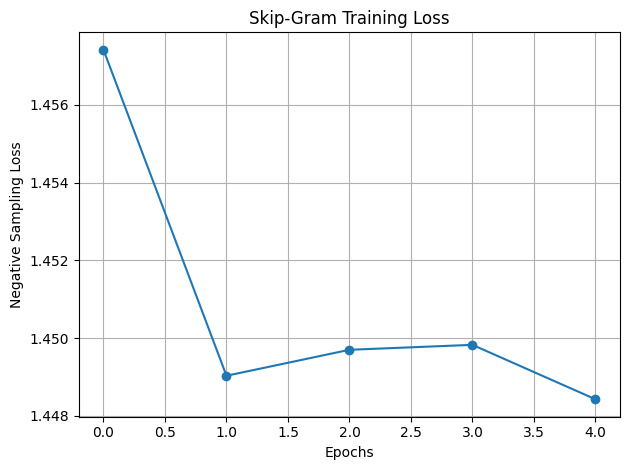

 ****************************  SkipGram model with embedding_dim = 300 **********************
Starting Skip-Gram training...


Epoch 1/5 completed. Avg Loss: 1.4655


Epoch 2/5 completed. Avg Loss: 1.4588


Epoch 3/5 completed. Avg Loss: 1.4576


Epoch 4/5 completed. Avg Loss: 1.4577


Epoch 5/5 completed. Avg Loss: 1.4578

Training complete. Total time: 425.71s for 5 epochs.


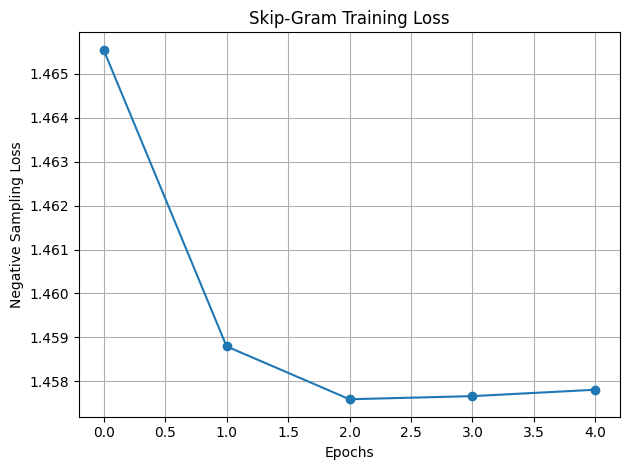

 ****************************  SkipGram model with embedding_dim = 512 **********************
Starting Skip-Gram training...


Epoch 1/5 completed. Avg Loss: 1.4742


Epoch 2/5 completed. Avg Loss: 1.4668


Epoch 3/5 completed. Avg Loss: 1.4670


Epoch 4/5 completed. Avg Loss: 1.4670


Epoch 5/5 completed. Avg Loss: 1.4663

Training complete. Total time: 421.98s for 5 epochs.


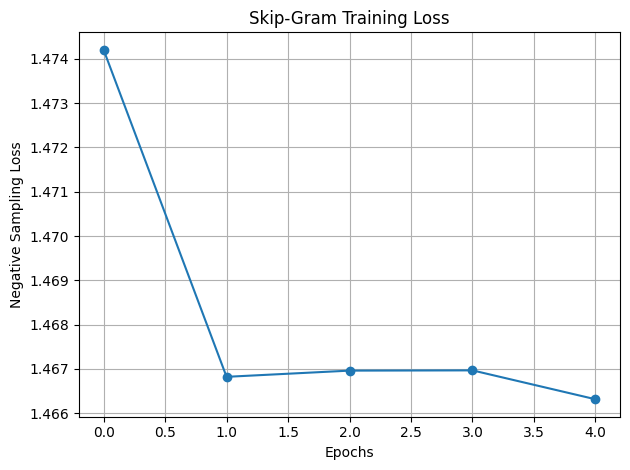

In [13]:
# Hyperparameters
embedding_dim   = 50   # size of embedding vectors
epochs          = 5
batch_size      = 64
neg_sample_size = 5    # K negative samples per example
learning_rate   = 0.01

import time

def train_skipgram_model(
    model,
    skipgram_pairs,
    vocab_size,
    optimizer,
    loss_fn=None,
    neg_sample_size=5,
    epochs=5,
    batch_size=64,
    device='cpu',
    plot=True
):
    print("Starting Skip-Gram training...")
    total_start = time.time()
    losses = []

    pairs_arr = np.array(skipgram_pairs)
    num_batches = len(pairs_arr) // batch_size

    for epoch in range(epochs):
        np.random.shuffle(pairs_arr)
        total_loss = 0.0
        progress_bar = tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for i in progress_bar:
            batch_pairs = pairs_arr[i * batch_size: (i + 1) * batch_size]

            target_idxs = torch.LongTensor(batch_pairs[:, 0]).to(device)
            context_idxs = torch.LongTensor(batch_pairs[:, 1]).to(device)

            # Sample K negative context words for each target
            negative_idxs = np.random.choice(vocab_size, (batch_size, neg_sample_size), replace=True)
            negative_idxs = torch.LongTensor(negative_idxs).to(device)

            pos_score, neg_score = model(target_idxs, context_idxs, negative_idxs)

            if loss_fn is None:
                loss = negative_sampling_loss(pos_score, neg_score)
            else:
                loss = loss_fn(pos_score, neg_score)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        avg_loss = total_loss / num_batches
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} completed. Avg Loss: {avg_loss:.4f}")

    total_time = time.time() - total_start
    print(f"\nTraining complete. Total time: {total_time:.2f}s for {epochs} epochs.")

    if plot:
        plt.plot(losses, marker='o')
        plt.xlabel("Epochs")
        plt.ylabel("Negative Sampling Loss")
        plt.title("Skip-Gram Training Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return losses, total_time


#PK NEW EDIT BETTER 
embedding_dims = [50, 100, 300, 512]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


models_sg = {}
optimizers_sg = {}
losses_sg = {}
times_sg = {}

for dim in embedding_dims:
    print(f" ****************************  SkipGram model with embedding_dim = {dim} **********************")
    
    model = SkipGramNegativeSampling(vocab_size, dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    losses, time_taken = train_skipgram_model(
        model=model,
        skipgram_pairs=skipgram_pairs_train,
        vocab_size=vocab_size,
        optimizer=optimizer,
        neg_sample_size=neg_sample_size,
        epochs=epochs,
        batch_size=batch_size,
        device=device,
        plot=True
    )

    
    models_sg[dim] = model
    optimizers_sg[dim] = optimizer
    losses_sg[dim] = losses
    times_sg[dim] = time_taken




In [14]:
import pandas as pd

rows = [
    {"epoch": epochs, "dim": dim, "batch_size": batch_size, "total_time": times_sg[dim]}
    for dim in embedding_dims
]

df = pd.DataFrame(rows)
print("********** SkipGram Model Training Time Summary *************")
display(df)


********** SkipGram Model Training Time Summary *************


,epoch,dim,batch_size,total_time
0,5,50,64,410.722148
1,5,100,64,402.726242
2,5,300,64,425.707418
3,5,512,64,421.981613


# 7. Extract Word2Vec Embeddings

In [15]:
def smiles_to_embedding(smiles_str, model, token_to_idx):
    """
    Converts a SMILES string to an average of its token embeddings
    (character-level).
    Returns a numpy array of shape (embedding_dim,).
    """
    tokens = tokenize_smiles(smiles_str)
    vectors = []
    for t in tokens:
        if t in token_to_idx:
            idx = token_to_idx[t]
            # Extract the learned target embedding
            emb = model.embedding_v.weight[idx].detach().cpu().numpy()
            vectors.append(emb)

    if len(vectors) == 0:
        # If no valid tokens found, return zero vector
        return np.zeros(model.embedding_dim)
    else:
        return np.mean(vectors, axis=0)


def get_all_embeddings(smiles_list, models, token_to_idx):
    """
    helper to aggregate them all embeddingsdings
    """
    all_embeddings = [[] for _ in models]

    for s in smiles_list:
        for i, model in enumerate(models):
            vec = smiles_to_embedding(s, model, token_to_idx)
            all_embeddings[i].append(vec)

    return [np.array(embed_list) for embed_list in all_embeddings]


model_sg_50, model_sg_100, model_sg_300, model_sg_512= models_sg[50], models_sg[100],models_sg[300], models_sg[512]

models = [model_sg_50, model_sg_100, model_sg_300, model_sg_512]

train_embeddings_50, train_embeddings_100, train_embeddings_300, train_embeddings_512 = get_all_embeddings(smiles_train, models, token_to_idx)
test_embeddings_50, test_embeddings_100, test_embeddings_300, test_embeddings_512  = get_all_embeddings(smiles_test, models, token_to_idx)



In [16]:
print(train_embeddings_50.shape)
print(train_embeddings_100.shape)
print(train_embeddings_300.shape)

(8447, 50)
(8447, 100)
(8447, 300)


In [24]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, classification_report
)
from imblearn.over_sampling import SMOTE
from collections import defaultdict
import matplotlib.pyplot as plt
import copy
import time
import warnings
from sklearn.model_selection import StratifiedKFold


device = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------------------------------
# Dataset wrapper for embedding data : Same as original
# ----------------------------------------
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        x = self.embeddings[idx]
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# ----------------------------------------
# Simple MLP for binary classification : same as original From saya's code
# ----------------------------------------
class ShallowMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(64, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1)


# ----------------------------------------
# Train with early stopping : Original Code by Saya
# ----------------------------------------
def run_shallow_mlp(
    train_loader,
    val_loader,
    test_loader=None,
    epochs=30,
    lr=1e-3,
    patience=50,
    min_delta=1e-4,
    device=device,
    verbose=False  # <- PK EDIT: Added toggle for optional printing/plotting
):
    input_dim = train_loader.dataset[0][0].shape[0]
    model = ShallowMLP(input_dim).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.BCELoss()

    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    best_state_dict = None
    epochs_no_improve = 0

    total_training_time_start = time.time()
    early_stop_epoch_time = None

    for ep in range(epochs):
        model.train()
        tloss = 0.0
        for xb, yb in tqdm(train_loader, desc=f"Epoch {ep+1}/{epochs} [train]", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            loss = crit(model(xb), yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            tloss += loss.item() * xb.size(0)
            

        tloss /= len(train_loader.dataset)
        train_losses.append(tloss)

        # Validation pass
        model.eval()
        vloss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                vloss += crit(model(xb), yb).item() * xb.size(0)
        vloss /= len(val_loader.dataset)
        val_losses.append(vloss)

        #PK EDIT BEGINS
        if verbose:
            print(f"Epoch {ep+1:02d} | Train {tloss:.4f} | Val {vloss:.4f}")

        # Early stopping logic
        if vloss + min_delta < best_val_loss:
            best_val_loss = vloss
            best_state_dict = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                if verbose:
                    print(f"⏹️  Early stop at epoch {ep+1} (no val improvement for {patience} epochs).")
                early_stop_epoch_time = time.time()
                break

    # Restore best model weights
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    # Time reporting
    total_training_time_end = time.time()
    total_training_duration = total_training_time_end - total_training_time_start
    time_to_early_stop = (
        early_stop_epoch_time - total_training_time_start
        if early_stop_epoch_time
        else total_training_duration
    )

    if verbose:
        print(f"\n***** Total training time: {total_training_duration:.2f} seconds")
        if early_stop_epoch_time:
            print(f"Time until early stop: {time_to_early_stop:.2f} seconds (at epoch {ep+1})")

        # Plot training + val loss
        plt.figure(figsize=(7, 4))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Val Loss")
        plt.axvline(len(train_losses) - epochs_no_improve - 1, linestyle="--", alpha=0.4, label="Best epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Shallow MLP – Training vs Validation Loss (early‑stopping)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return {
        "state_dict": model.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "model": model,
        "total_training_duration": total_training_duration,
        "time_to_early_stop": time_to_early_stop    
    }


# ----------------------------------------
# Evaluate model and collect per-class metrics + ROC/PR curves
# ----------------------------------------
def evaluate_model_with_report(model, loader):
    model.eval()
    all_probs, all_preds, all_tgts = [], [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            probs = model(xb).cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_tgts.extend(yb.numpy())

    y_true = np.array(all_tgts)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)

    # Generate detailed classification report (dict)
    report = classification_report(y_true, y_pred, output_dict=True)

    return report, y_true, y_prob


## PK EDITS : K CROSS VALIDATIONS
###
#Define standard scaler helper

def scale_fold_data(X_train, X_val, X_test):

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_val_scaled, X_test_scaled


# Run k-fold CV, print per-fold reports, and aggregate metrics + ROC curve

def mean_confidence_interval(data, confidence=0.95):
    a = np.array(data)
    a = a[~np.isnan(a)]  # Remove NaNs
    if len(a) == 0:
        return np.nan, np.nan
    mean = np.mean(a)
    sem = np.std(a, ddof=1) / np.sqrt(len(a))
    h = sem * 1.96
    return mean, h

def analyze_results(fold_metrics, metric='f1-score', cls='0'):
    scores = [fold[cls][metric] for fold in fold_metrics if cls in fold and metric in fold[cls]]
    mean, ci95 = mean_confidence_interval(scores)
    print(f"{metric.upper()} (Class {cls}): {mean:.4f} ± {ci95:.4f}")
    return scores

def plot_roc_curves(curve_data, cls=1, title='ROC Curve'):
    plt.figure(figsize=(8, 6))
    for i, entry in enumerate(curve_data):
        if entry['class'] == cls:
            plt.plot(entry['fpr'], entry['tpr'], label=f"Fold {i+1}")
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title(f"{title} (Class {cls})")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----------------------------------------
# Main K-Fold CV with optional per-fold ROC : Note this is FOR DL MODULes
# ----------------------------------------
def stratified_fold_cv(
    embeddings,
    labels,
    X_test_ext,
    y_test_ext,
    smote=False,
    k=5,
    batch_size=64,
    seed=24,
    verbose=False,
    return_fold_roc=False,
    num_gpus=1,
    epochs = 30# 
):
    from time import time

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

    all_reports = []
    all_y_true = []
    all_y_prob = []
    fold_roc_data = []

    print(f"\n@@@@@@@@ Running {k}-Fold Cross Validation with external test set @@@@@@@@\n")

    #  Start total timer
    start_all = time()

    for fold, (train_data_idx, val_data_idx) in enumerate(skf.split(embeddings, labels), 1):
        print(f"\n--- Fold {fold}/{k} ---")

        X_train_fold = embeddings[train_data_idx]
        y_train_fold = labels[train_data_idx]
        X_val_fold = embeddings[val_data_idx]
        y_val_fold = labels[val_data_idx]

        if smote:
            X_train_fold, y_train_fold = SMOTE(random_state=seed).fit_resample(X_train_fold, y_train_fold)

        # Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_val_scaled = scaler.transform(X_val_fold)
        X_test_scaled = scaler.transform(X_test_ext)

        # Loaders
        train_loader = DataLoader(EmbeddingDataset(X_train_scaled, y_train_fold), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(EmbeddingDataset(X_val_scaled, y_val_fold), batch_size=batch_size)
        test_loader = DataLoader(EmbeddingDataset(X_test_scaled, y_test_ext), batch_size=batch_size)

        # Train model
        result = run_shallow_mlp(train_loader, val_loader, verbose=verbose, epochs = epochs)
        model = result["model"]
        model.load_state_dict(result["state_dict"])

        # Evaluate on external test set
        report, y_true_fold, y_prob_fold = evaluate_model_with_report(model, test_loader)

        print(f"\nClassification report for fold {fold}:\n")
        print(classification_report(y_true_fold, (y_prob_fold >= 0.5).astype(int)))

        all_reports.append(report)
        all_y_true.append(y_true_fold)
        all_y_prob.append(y_prob_fold)

        # Store ROC if requested
        if return_fold_roc:
            fpr, tpr, _ = roc_curve(y_true_fold, y_prob_fold)
            fold_roc_data.append({'class': 1, 'fpr': fpr, 'tpr': tpr})

    #  End total timer
    end_all = time()
    total_time_sec = end_all - start_all
    total_time_hr = total_time_sec / 3600
    total_gpu_hours = total_time_hr * num_gpus

    print(f"\n\n Total training time across {k} folds: {total_time_sec:.2f} seconds ({total_time_hr:.2f} hours)")
    print(f"Approximate GPU usage: {total_gpu_hours:.2f} GPU hours (using {num_gpus} GPU(s))\n")

    # --------------------
    # Aggregated Metrics
    # --------------------
    metric_keys = ['precision', 'recall', 'f1-score', 'support']
    aggregated_metrics = defaultdict(lambda: defaultdict(list))
    accuracies = []

    for report in all_reports:
        for cls_or_avg, metrics in report.items():
            if isinstance(metrics, dict):
                for metric_key in metric_keys:
                    if metric_key in metrics:
                        aggregated_metrics[cls_or_avg][metric_key].append(metrics[metric_key])
        if 'accuracy' in report:
            accuracies.append(report['accuracy'])

    print("\nAggregated metrics across folds:\n")
    for cls_or_avg in aggregated_metrics.keys():
        print(f"Class/Average: {cls_or_avg}")
        for metric_key in metric_keys:
            vals = aggregated_metrics[cls_or_avg][metric_key]
            mean, ci95 = mean_confidence_interval(vals)
            print(f"  {metric_key}: {mean:.4f} ± {ci95:.4f}")
        print()

    if accuracies:
        mean_acc, ci95_acc = mean_confidence_interval(accuracies)
        print(f"Overall Accuracy: {mean_acc:.4f} ± {ci95_acc:.4f}")

    # --------------------
    # Aggregated ROC Curve
    # --------------------
    y_true_agg = np.concatenate(all_y_true)
    y_prob_agg = np.concatenate(all_y_prob)

    fpr, tpr, _ = roc_curve(y_true_agg, y_prob_agg)
    auc_score = roc_auc_score(y_true_agg, y_prob_agg)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'Aggregated ROC (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Aggregated ROC Curve Across All Folds')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return all_reports, (y_true_agg, y_prob_agg), fold_roc_data if return_fold_roc else None, total_time_sec


## PK EDIT 2: For SCIKIT LEARN MODELS : ONLY FOR ML RF, LOgistic Regression
def stratified_fold_cv_scikit(embeddings, labels, X_test_ext, y_test_ext,
                              smote=False, k=5, seed=69, verbose=False,
                              return_fold_roc=False, clf=None):
    
    if clf is None:
        from sklearn.ensemble import RandomForestClassifier
        clf = RandomForestClassifier(random_state=seed)

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

    all_reports = []
    all_y_true = []
    all_y_prob = []
    fold_roc_data = []

    print(f"Running {k}-Fold Cross Validation with external test set...")

    overall_start_time = time.time()

    for fold, (train_idx, _) in enumerate(skf.split(embeddings, labels), 1):
        fold_start_time = time.time()
        print(f"\n--- Fold {fold}/{k} ---")

        X_train = embeddings[train_idx]
        y_train = labels[train_idx]

        if smote:
            X_train, y_train = SMOTE(random_state=seed).fit_resample(X_train, y_train)

        # Optionally split a small validation set if needed
        val_split = int(0.9 * len(X_train))
        X_val, y_val = X_train[val_split:], y_train[val_split:]
        X_train, y_train = X_train[:val_split], y_train[:val_split]

        # Scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)  # Not used but retained for possible future use
        X_test_scaled = scaler.transform(X_test_ext)

        # Train classifier
        model = clf
        model.fit(X_train_scaled, y_train)

        # Predict on test set
        if hasattr(model, "predict_proba"):
            y_prob_fold = model.predict_proba(X_test_scaled)[:, 1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test_scaled)
            y_prob_fold = (y_score - y_score.min()) / (y_score.max() - y_score.min())
        else:
            raise ValueError("Classifier must support predict_proba or decision_function")

        y_pred_fold = (y_prob_fold >= 0.5).astype(int)
        report = classification_report(y_test_ext, y_pred_fold, output_dict=True)

        print(f"\nClassification report for fold {fold}:\n")
        print(classification_report(y_test_ext, y_pred_fold))

        all_reports.append(report)
        all_y_true.append(y_test_ext)
        all_y_prob.append(y_prob_fold)

        # Store ROC
        if return_fold_roc:
            fpr, tpr, _ = roc_curve(y_test_ext, y_prob_fold)
            fold_roc_data.append({'class': 1, 'fpr': fpr, 'tpr': tpr})

        fold_time = time.time() - fold_start_time
        print(f"Fold {fold} completed in {fold_time:.2f} seconds.")

    total_time = time.time() - overall_start_time
    print(f"\nTotal cross-validation time: {total_time:.2f} seconds.")

    # Aggregated metrics
    metric_keys = ['precision', 'recall', 'f1-score', 'support']
    aggregated_metrics = defaultdict(lambda: defaultdict(list))
    accuracies = []

    for report in all_reports:
        for cls_or_avg, metrics in report.items():
            if isinstance(metrics, dict):
                for metric_key in metric_keys:
                    if metric_key in metrics:
                        aggregated_metrics[cls_or_avg][metric_key].append(metrics[metric_key])
        if 'accuracy' in report:
            accuracies.append(report['accuracy'])

    print("\n\nAggregated metrics across folds:\n")
    for cls_or_avg in aggregated_metrics.keys():
        print(f"Class/Average: {cls_or_avg}")
        for metric_key in metric_keys:
            vals = aggregated_metrics[cls_or_avg][metric_key]
            mean, ci95 = mean_confidence_interval(vals)
            print(f"  {metric_key}: {mean:.4f} ± {ci95:.4f}")
        print()

    if accuracies:
        mean_acc, ci95_acc = mean_confidence_interval(accuracies)
        print(f"Overall Accuracy: {mean_acc:.4f} ± {ci95_acc:.4f}")

    # Aggregated ROC
    y_true_agg = np.concatenate(all_y_true)
    y_prob_agg = np.concatenate(all_y_prob)

    fpr, tpr, _ = roc_curve(y_true_agg, y_prob_agg)
    auc_score = roc_auc_score(y_true_agg, y_prob_agg)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'Aggregated ROC (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Aggregated ROC Curve Across All Folds')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return all_reports, (y_true_agg, y_prob_agg), fold_roc_data if return_fold_roc else None


# ----------------------------------------
# Analyze results: mean + 95% CI for a class: GPT generated
# ----------------------------------------
def mean_confidence_interval(data, confidence=0.95):
    a = np.array(data)
    a = a[~np.isnan(a)]  # Remove NaNs
    if len(a) == 0:
        return np.nan, np.nan
    mean = np.mean(a)
    sem = np.std(a, ddof=1) / np.sqrt(len(a))
    h = sem * 1.96
    return mean, h

def analyze_results(fold_metrics, metric='f1-score', cls='0'):
    # Try both string and int keys
    str_cls = str(cls)
    int_cls = int(cls) if isinstance(cls, str) and cls.isdigit() else None

    scores = []
    for fold in fold_metrics:
        if str_cls in fold and metric in fold[str_cls]:
            scores.append(fold[str_cls][metric])
        elif int_cls is not None and int_cls in fold and metric in fold[int_cls]:
            scores.append(fold[int_cls][metric])
    if not scores:
        print(f"No scores found for metric '{metric}' and class '{cls}'")
        return []
    mean, ci95 = mean_confidence_interval(scores)
    print(f"{metric.upper()} (Class {cls}): {mean:.4f} ± {ci95:.4f}")
    return scores

# ----------------------------------------
# Plot ROC for one class across folds : GPT generated
# ----------------------------------------

def analyze_accuracy(fold_metrics):
    accuracies = []
    for report in fold_metrics:
        if 'accuracy' in report:
            accuracies.append(report['accuracy'])
    if not accuracies:
        print("No accuracy scores found")
        return []
    mean, ci95 = mean_confidence_interval(accuracies)
    print(f"Accuracy: {mean:.4f} ± {ci95:.4f}")
    return accuracies



# ----------------------------------------
# Plot ROC for one class across folds : GPT generated
# ----------------------------------------

def plot_roc_curves(curve_data, cls=1, title='ROC Curve'):
    plt.figure(figsize=(8, 6))
    for i, entry in enumerate(curve_data):
        if entry['class'] == cls:
            plt.plot(entry['fpr'], entry['tpr'], label=f"Fold {i+1}")
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title(f"{title} (Class {cls})")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()






####### Processing 50D without SMOTE #######


@@@@@@@@ Running 5-Fold Cross Validation with external test set @@@@@@@@


--- Fold 1/5 ---



Classification report for fold 1:

              precision    recall  f1-score   support

         0.0       0.68      0.55      0.61       381
         1.0       0.73      0.82      0.77       558

    accuracy                           0.71       939
   macro avg       0.71      0.69      0.69       939
weighted avg       0.71      0.71      0.71       939


--- Fold 2/5 ---



Classification report for fold 2:

              precision    recall  f1-score   support

         0.0       0.66      0.58      0.62       381
         1.0       0.74      0.80      0.77       558

    accuracy                           0.71       939
   macro avg       0.70      0.69      0.69       939
weighted avg       0.71      0.71      0.71       939


--- Fold 3/5 ---



Classification report for fold 3:

              precision    recall  f1-score   support

         0.0       0.69      0.56      0.62       381
         1.0       0.73      0.83      0.78       558

    accuracy                           0.72       939
   macro avg       0.71      0.69      0.70       939
weighted avg       0.71      0.72      0.71       939


--- Fold 4/5 ---



Classification report for fold 4:

              precision    recall  f1-score   support

         0.0       0.67      0.54      0.59       381
         1.0       0.72      0.82      0.77       558

    accuracy                           0.70       939
   macro avg       0.69      0.68      0.68       939
weighted avg       0.70      0.70      0.70       939


--- Fold 5/5 ---



Classification report for fold 5:

              precision    recall  f1-score   support

         0.0       0.72      0.54      0.62       381
         1.0       0.73      0.85      0.79       558

    accuracy                           0.73       939
   macro avg       0.73      0.70      0.70       939
weighted avg       0.73      0.73      0.72       939



 Total training time across 5 folds: 57.05 seconds (0.02 hours)
Approximate GPU usage: 0.02 GPU hours (using 1 GPU(s))


Aggregated metrics across folds:

Class/Average: 0.0
  precision: 0.6847 ± 0.0187
  recall: 0.5543 ± 0.0157
  f1-score: 0.6123 ± 0.0092
  support: 381.0000 ± 0.0000

Class/Average: 1.0
  precision: 0.7306 ± 0.0053
  recall: 0.8251 ± 0.0175
  f1-score: 0.7749 ± 0.0080
  support: 558.0000 ± 0.0000

Class/Average: macro avg
  precision: 0.7076 ± 0.0102
  recall: 0.6897 ± 0.0070
  f1-score: 0.6936 ± 0.0073
  support: 939.0000 ± 0.0000

Class/Average: weighted avg
  precision: 0.7120 ± 0.0088
  recall: 0.7152 ± 0.

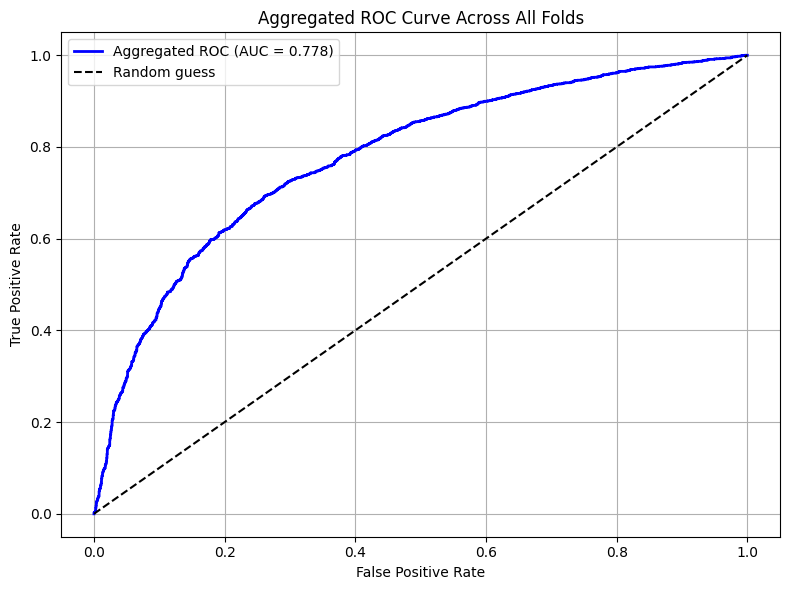

F1-SCORE (Class 0.0): 0.6123 ± 0.0092
F1-SCORE (Class 1.0): 0.7749 ± 0.0080
F1-SCORE (Class macro avg): 0.6936 ± 0.0073
Accuracy: 0.7152 ± 0.0079


####### Processing 100D without SMOTE #######


@@@@@@@@ Running 5-Fold Cross Validation with external test set @@@@@@@@


--- Fold 1/5 ---



Classification report for fold 1:

              precision    recall  f1-score   support

         0.0       0.68      0.56      0.61       381
         1.0       0.73      0.82      0.77       558

    accuracy                           0.71       939
   macro avg       0.70      0.69      0.69       939
weighted avg       0.71      0.71      0.71       939


--- Fold 2/5 ---



Classification report for fold 2:

              precision    recall  f1-score   support

         0.0       0.65      0.64      0.64       381
         1.0       0.76      0.77      0.76       558

    accuracy                           0.71       939
   macro avg       0.70      0.70      0.70       939
weighted avg       0.71      0.71      0.71       939


--- Fold 3/5 ---



Classification report for fold 3:

              precision    recall  f1-score   support

         0.0       0.68      0.54      0.60       381
         1.0       0.72      0.83      0.77       558

    accuracy                           0.71       939
   macro avg       0.70      0.68      0.69       939
weighted avg       0.71      0.71      0.70       939


--- Fold 4/5 ---



Classification report for fold 4:

              precision    recall  f1-score   support

         0.0       0.69      0.58      0.63       381
         1.0       0.74      0.82      0.78       558

    accuracy                           0.72       939
   macro avg       0.71      0.70      0.70       939
weighted avg       0.72      0.72      0.72       939


--- Fold 5/5 ---



Classification report for fold 5:

              precision    recall  f1-score   support

         0.0       0.68      0.56      0.61       381
         1.0       0.73      0.82      0.77       558

    accuracy                           0.72       939
   macro avg       0.71      0.69      0.69       939
weighted avg       0.71      0.72      0.71       939



 Total training time across 5 folds: 53.26 seconds (0.01 hours)
Approximate GPU usage: 0.01 GPU hours (using 1 GPU(s))


Aggregated metrics across folds:

Class/Average: 0.0
  precision: 0.6759 ± 0.0121
  recall: 0.5738 ± 0.0325
  f1-score: 0.6199 ± 0.0143
  support: 381.0000 ± 0.0000

Class/Average: 1.0
  precision: 0.7364 ± 0.0105
  recall: 0.8115 ± 0.0212
  f1-score: 0.7718 ± 0.0053
  support: 558.0000 ± 0.0000

Class/Average: macro avg
  precision: 0.7062 ± 0.0040
  recall: 0.6926 ± 0.0069
  f1-score: 0.6958 ± 0.0062
  support: 939.0000 ± 0.0000

Class/Average: weighted avg
  precision: 0.7119 ± 0.0041
  recall: 0.7150 ± 0.

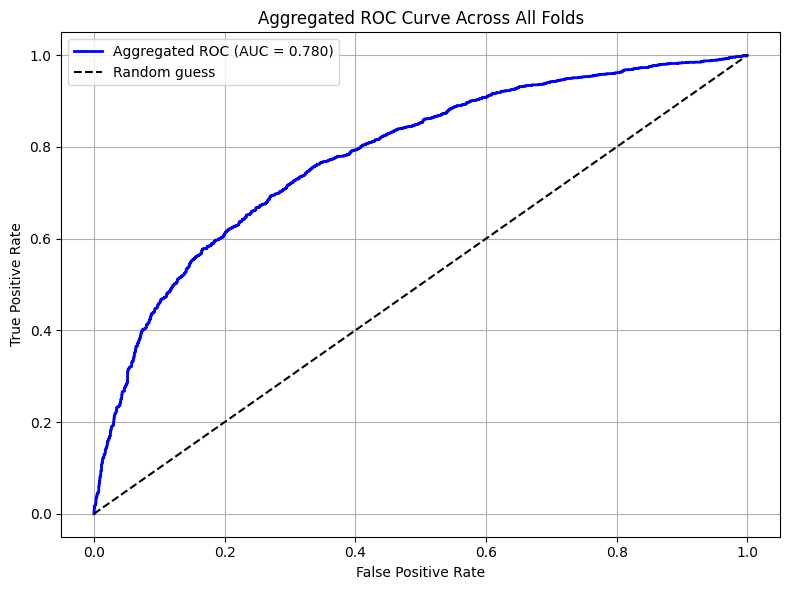

F1-SCORE (Class 0.0): 0.6199 ± 0.0143
F1-SCORE (Class 1.0): 0.7718 ± 0.0053
F1-SCORE (Class macro avg): 0.6958 ± 0.0062
Accuracy: 0.7150 ± 0.0039


####### Processing 300D without SMOTE #######


@@@@@@@@ Running 5-Fold Cross Validation with external test set @@@@@@@@


--- Fold 1/5 ---



Classification report for fold 1:

              precision    recall  f1-score   support

         0.0       0.67      0.58      0.62       381
         1.0       0.74      0.80      0.77       558

    accuracy                           0.71       939
   macro avg       0.70      0.69      0.69       939
weighted avg       0.71      0.71      0.71       939


--- Fold 2/5 ---



Classification report for fold 2:

              precision    recall  f1-score   support

         0.0       0.69      0.55      0.61       381
         1.0       0.73      0.83      0.78       558

    accuracy                           0.71       939
   macro avg       0.71      0.69      0.69       939
weighted avg       0.71      0.71      0.71       939


--- Fold 3/5 ---



Classification report for fold 3:

              precision    recall  f1-score   support

         0.0       0.69      0.56      0.62       381
         1.0       0.73      0.83      0.78       558

    accuracy                           0.72       939
   macro avg       0.71      0.69      0.70       939
weighted avg       0.72      0.72      0.71       939


--- Fold 4/5 ---



Classification report for fold 4:

              precision    recall  f1-score   support

         0.0       0.67      0.61      0.64       381
         1.0       0.75      0.80      0.77       558

    accuracy                           0.72       939
   macro avg       0.71      0.70      0.70       939
weighted avg       0.72      0.72      0.72       939


--- Fold 5/5 ---



Classification report for fold 5:

              precision    recall  f1-score   support

         0.0       0.67      0.55      0.61       381
         1.0       0.73      0.82      0.77       558

    accuracy                           0.71       939
   macro avg       0.70      0.68      0.69       939
weighted avg       0.70      0.71      0.70       939



 Total training time across 5 folds: 56.39 seconds (0.02 hours)
Approximate GPU usage: 0.02 GPU hours (using 1 GPU(s))


Aggregated metrics across folds:

Class/Average: 0.0
  precision: 0.6774 ± 0.0091
  recall: 0.5690 ± 0.0219
  f1-score: 0.6182 ± 0.0112
  support: 381.0000 ± 0.0000

Class/Average: 1.0
  precision: 0.7348 ± 0.0076
  recall: 0.8147 ± 0.0129
  f1-score: 0.7726 ± 0.0038
  support: 558.0000 ± 0.0000

Class/Average: macro avg
  precision: 0.7061 ± 0.0048
  recall: 0.6919 ± 0.0062
  f1-score: 0.6954 ± 0.0059
  support: 939.0000 ± 0.0000

Class/Average: weighted avg
  precision: 0.7115 ± 0.0048
  recall: 0.7150 ± 0.

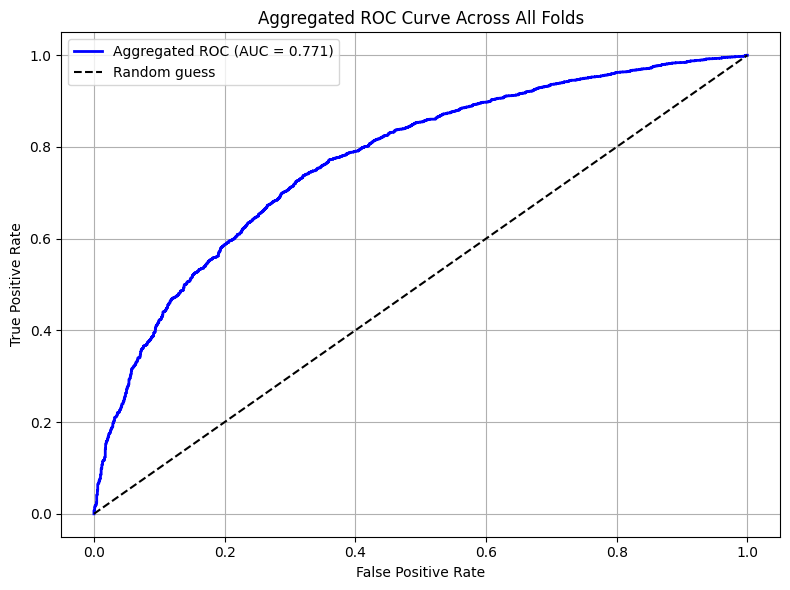

F1-SCORE (Class 0.0): 0.6182 ± 0.0112
F1-SCORE (Class 1.0): 0.7726 ± 0.0038
F1-SCORE (Class macro avg): 0.6954 ± 0.0059
Accuracy: 0.7150 ± 0.0044


####### Processing 512D without SMOTE #######


@@@@@@@@ Running 5-Fold Cross Validation with external test set @@@@@@@@


--- Fold 1/5 ---



Classification report for fold 1:

              precision    recall  f1-score   support

         0.0       0.69      0.62      0.65       381
         1.0       0.76      0.81      0.78       558

    accuracy                           0.73       939
   macro avg       0.72      0.71      0.72       939
weighted avg       0.73      0.73      0.73       939


--- Fold 2/5 ---



Classification report for fold 2:

              precision    recall  f1-score   support

         0.0       0.66      0.56      0.60       381
         1.0       0.73      0.81      0.76       558

    accuracy                           0.71       939
   macro avg       0.69      0.68      0.68       939
weighted avg       0.70      0.71      0.70       939


--- Fold 3/5 ---



Classification report for fold 3:

              precision    recall  f1-score   support

         0.0       0.66      0.55      0.60       381
         1.0       0.72      0.80      0.76       558

    accuracy                           0.70       939
   macro avg       0.69      0.68      0.68       939
weighted avg       0.70      0.70      0.69       939


--- Fold 4/5 ---



Classification report for fold 4:

              precision    recall  f1-score   support

         0.0       0.67      0.51      0.58       381
         1.0       0.71      0.83      0.76       558

    accuracy                           0.70       939
   macro avg       0.69      0.67      0.67       939
weighted avg       0.69      0.70      0.69       939


--- Fold 5/5 ---



Classification report for fold 5:

              precision    recall  f1-score   support

         0.0       0.68      0.57      0.62       381
         1.0       0.74      0.82      0.78       558

    accuracy                           0.72       939
   macro avg       0.71      0.70      0.70       939
weighted avg       0.72      0.72      0.71       939



 Total training time across 5 folds: 60.16 seconds (0.02 hours)
Approximate GPU usage: 0.02 GPU hours (using 1 GPU(s))


Aggregated metrics across folds:

Class/Average: 0.0
  precision: 0.6720 ± 0.0128
  recall: 0.5612 ± 0.0354
  f1-score: 0.6112 ± 0.0253
  support: 381.0000 ± 0.0000

Class/Average: 1.0
  precision: 0.7311 ± 0.0153
  recall: 0.8133 ± 0.0080
  f1-score: 0.7699 ± 0.0081
  support: 558.0000 ± 0.0000

Class/Average: macro avg
  precision: 0.7015 ± 0.0134
  recall: 0.6872 ± 0.0164
  f1-score: 0.6905 ± 0.0164
  support: 939.0000 ± 0.0000

Class/Average: weighted avg
  precision: 0.7071 ± 0.0137
  recall: 0.7110 ± 0.

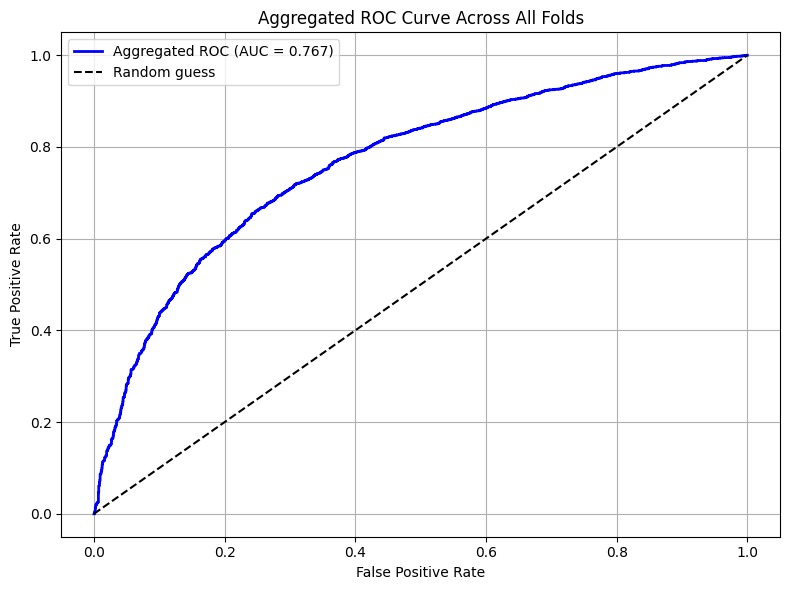

F1-SCORE (Class 0.0): 0.6112 ± 0.0253
F1-SCORE (Class 1.0): 0.7699 ± 0.0081
F1-SCORE (Class macro avg): 0.6905 ± 0.0164
Accuracy: 0.7110 ± 0.0131


In [25]:
embedding_dims = [50, 100, 300, 512]
results_summary = []
all_ytrue_yprob = {}  # For ROC/PR curves

# ---- Without SMOTE ----
for dim in embedding_dims:
    print(f"\n\n####### Processing {dim}D without SMOTE #######\n")
    X = np.array(eval(f"train_embeddings_{dim}"))
    y = np.array(labels_train)
    X_test_ext = np.array(eval(f"test_embeddings_{dim}"))
    y_test_ext = np.array(labels_test)

    reports, (y_true, y_prob), _, train_time = stratified_fold_cv(
        X, y, X_test_ext, y_test_ext,
        smote=False,
        k=5,
        verbose=False,
        return_fold_roc=True,
        num_gpus=1,
        epochs = 30
    )

    # Save for plotting
    all_ytrue_yprob[f"Dim {dim}"] = (y_true, y_prob)

    # Extract stats
    f1_0 = analyze_results(reports, metric='f1-score', cls=0.0)
    f1_1 = analyze_results(reports, metric='f1-score', cls=1.0)
    macro_f1 = analyze_results(reports, metric='f1-score', cls='macro avg')
    acc = analyze_accuracy(reports)
    auc_val = roc_auc_score(y_true, y_prob)
    
    results_summary.append({
        "Model": f"MLP ({dim}d)",
        "Accuracy": f"{np.mean(acc):.4f} ± {mean_confidence_interval(acc)[1]:.4f}",
        "F1_0": f"{np.mean(f1_0):.4f} ± {mean_confidence_interval(f1_0)[1]:.4f}",
        "F1_1": f"{np.mean(f1_1):.4f} ± {mean_confidence_interval(f1_1)[1]:.4f}",
        "Macro_F1": f"{np.mean(macro_f1):.4f} ± {mean_confidence_interval(macro_f1)[1]:.4f}",
        "ROC_AUC": f"{auc_val:.4f}",
        "Total Time (s)": f"{train_time:.4f}",
        "SMOTE": "No"
    })






####### Processing 50D WITH SMOTE #######


@@@@@@@@ Running 5-Fold Cross Validation with external test set @@@@@@@@


--- Fold 1/5 ---



Classification report for fold 1:

              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68       381
         1.0       0.78      0.78      0.78       558

    accuracy                           0.74       939
   macro avg       0.73      0.73      0.73       939
weighted avg       0.74      0.74      0.74       939


--- Fold 2/5 ---



Classification report for fold 2:

              precision    recall  f1-score   support

         0.0       0.66      0.64      0.65       381
         1.0       0.76      0.77      0.77       558

    accuracy                           0.72       939
   macro avg       0.71      0.71      0.71       939
weighted avg       0.72      0.72      0.72       939


--- Fold 3/5 ---



Classification report for fold 3:

              precision    recall  f1-score   support

         0.0       0.67      0.66      0.66       381
         1.0       0.77      0.78      0.77       558

    accuracy                           0.73       939
   macro avg       0.72      0.72      0.72       939
weighted avg       0.73      0.73      0.73       939


--- Fold 4/5 ---



Classification report for fold 4:

              precision    recall  f1-score   support

         0.0       0.67      0.65      0.66       381
         1.0       0.76      0.78      0.77       558

    accuracy                           0.73       939
   macro avg       0.71      0.71      0.71       939
weighted avg       0.72      0.73      0.72       939


--- Fold 5/5 ---



Classification report for fold 5:

              precision    recall  f1-score   support

         0.0       0.65      0.63      0.64       381
         1.0       0.75      0.77      0.76       558

    accuracy                           0.71       939
   macro avg       0.70      0.70      0.70       939
weighted avg       0.71      0.71      0.71       939



 Total training time across 5 folds: 68.80 seconds (0.02 hours)
Approximate GPU usage: 0.02 GPU hours (using 1 GPU(s))


Aggregated metrics across folds:

Class/Average: 0.0
  precision: 0.6644 ± 0.0094
  recall: 0.6509 ± 0.0165
  f1-score: 0.6576 ± 0.0130
  support: 381.0000 ± 0.0000

Class/Average: 1.0
  precision: 0.7650 ± 0.0094
  recall: 0.7756 ± 0.0041
  f1-score: 0.7703 ± 0.0066
  support: 558.0000 ± 0.0000

Class/Average: macro avg
  precision: 0.7147 ± 0.0094
  recall: 0.7133 ± 0.0101
  f1-score: 0.7139 ± 0.0098
  support: 939.0000 ± 0.0000

Class/Average: weighted avg
  precision: 0.7242 ± 0.0094
  recall: 0.7250 ± 0.

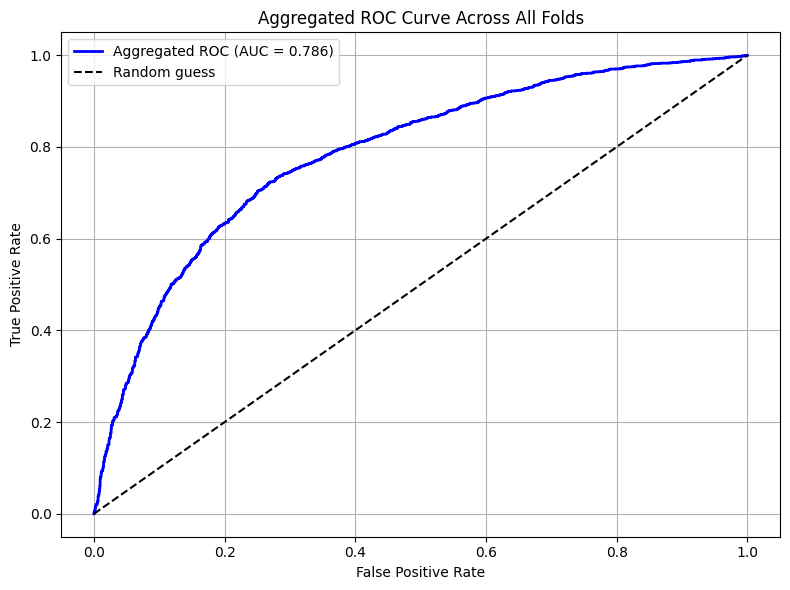

F1-SCORE (Class 0.0): 0.6576 ± 0.0130
F1-SCORE (Class 1.0): 0.7703 ± 0.0066
F1-SCORE (Class macro avg): 0.7139 ± 0.0098
Accuracy: 0.7250 ± 0.0089


####### Processing 100D WITH SMOTE #######


@@@@@@@@ Running 5-Fold Cross Validation with external test set @@@@@@@@


--- Fold 1/5 ---



Classification report for fold 1:

              precision    recall  f1-score   support

         0.0       0.63      0.68      0.65       381
         1.0       0.77      0.72      0.75       558

    accuracy                           0.71       939
   macro avg       0.70      0.70      0.70       939
weighted avg       0.71      0.71      0.71       939


--- Fold 2/5 ---



Classification report for fold 2:

              precision    recall  f1-score   support

         0.0       0.64      0.65      0.65       381
         1.0       0.76      0.75      0.75       558

    accuracy                           0.71       939
   macro avg       0.70      0.70      0.70       939
weighted avg       0.71      0.71      0.71       939


--- Fold 3/5 ---



Classification report for fold 3:

              precision    recall  f1-score   support

         0.0       0.63      0.71      0.67       381
         1.0       0.78      0.72      0.75       558

    accuracy                           0.71       939
   macro avg       0.70      0.71      0.71       939
weighted avg       0.72      0.71      0.71       939


--- Fold 4/5 ---



Classification report for fold 4:

              precision    recall  f1-score   support

         0.0       0.67      0.61      0.64       381
         1.0       0.75      0.80      0.77       558

    accuracy                           0.72       939
   macro avg       0.71      0.70      0.71       939
weighted avg       0.72      0.72      0.72       939


--- Fold 5/5 ---



Classification report for fold 5:

              precision    recall  f1-score   support

         0.0       0.68      0.60      0.64       381
         1.0       0.75      0.81      0.78       558

    accuracy                           0.73       939
   macro avg       0.72      0.71      0.71       939
weighted avg       0.72      0.73      0.72       939



 Total training time across 5 folds: 65.18 seconds (0.02 hours)
Approximate GPU usage: 0.02 GPU hours (using 1 GPU(s))


Aggregated metrics across folds:

Class/Average: 0.0
  precision: 0.6511 ± 0.0230
  recall: 0.6509 ± 0.0387
  f1-score: 0.6495 ± 0.0089
  support: 381.0000 ± 0.0000

Class/Average: 1.0
  precision: 0.7619 ± 0.0117
  recall: 0.7595 ± 0.0375
  f1-score: 0.7599 ± 0.0133
  support: 558.0000 ± 0.0000

Class/Average: macro avg
  precision: 0.7065 ± 0.0069
  recall: 0.7052 ± 0.0032
  f1-score: 0.7047 ± 0.0038
  support: 939.0000 ± 0.0000

Class/Average: weighted avg
  precision: 0.7169 ± 0.0045
  recall: 0.7154 ± 0.

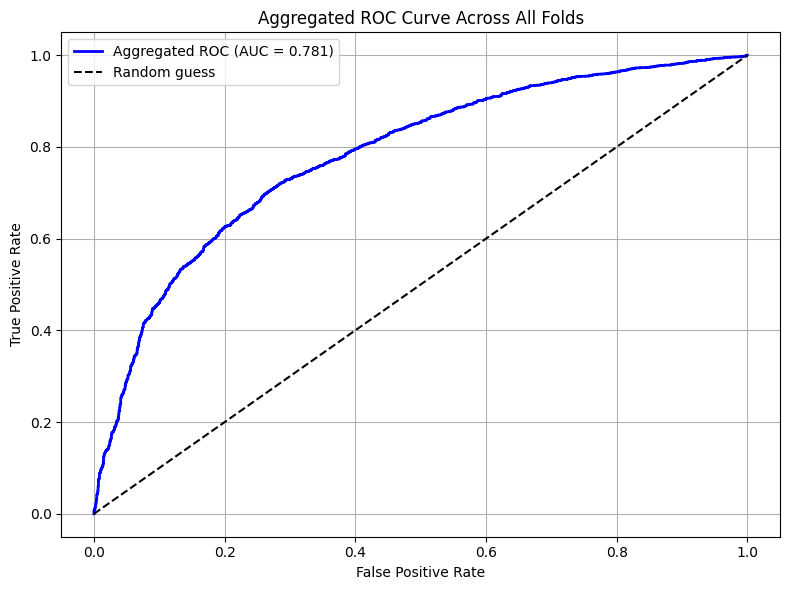

F1-SCORE (Class 0.0): 0.6495 ± 0.0089
F1-SCORE (Class 1.0): 0.7599 ± 0.0133
F1-SCORE (Class macro avg): 0.7047 ± 0.0038
Accuracy: 0.7154 ± 0.0072


####### Processing 300D WITH SMOTE #######


@@@@@@@@ Running 5-Fold Cross Validation with external test set @@@@@@@@


--- Fold 1/5 ---



Classification report for fold 1:

              precision    recall  f1-score   support

         0.0       0.65      0.67      0.66       381
         1.0       0.77      0.75      0.76       558

    accuracy                           0.72       939
   macro avg       0.71      0.71      0.71       939
weighted avg       0.72      0.72      0.72       939


--- Fold 2/5 ---



Classification report for fold 2:

              precision    recall  f1-score   support

         0.0       0.64      0.67      0.65       381
         1.0       0.77      0.75      0.76       558

    accuracy                           0.71       939
   macro avg       0.70      0.71      0.70       939
weighted avg       0.72      0.71      0.71       939


--- Fold 3/5 ---



Classification report for fold 3:

              precision    recall  f1-score   support

         0.0       0.63      0.69      0.66       381
         1.0       0.77      0.72      0.75       558

    accuracy                           0.71       939
   macro avg       0.70      0.70      0.70       939
weighted avg       0.71      0.71      0.71       939


--- Fold 4/5 ---



Classification report for fold 4:

              precision    recall  f1-score   support

         0.0       0.64      0.70      0.67       381
         1.0       0.78      0.74      0.76       558

    accuracy                           0.72       939
   macro avg       0.71      0.72      0.71       939
weighted avg       0.72      0.72      0.72       939


--- Fold 5/5 ---



Classification report for fold 5:

              precision    recall  f1-score   support

         0.0       0.65      0.65      0.65       381
         1.0       0.76      0.76      0.76       558

    accuracy                           0.72       939
   macro avg       0.71      0.71      0.71       939
weighted avg       0.72      0.72      0.72       939



 Total training time across 5 folds: 65.97 seconds (0.02 hours)
Approximate GPU usage: 0.02 GPU hours (using 1 GPU(s))


Aggregated metrics across folds:

Class/Average: 0.0
  precision: 0.6430 ± 0.0080
  recall: 0.6745 ± 0.0150
  f1-score: 0.6582 ± 0.0059
  support: 381.0000 ± 0.0000

Class/Average: 1.0
  precision: 0.7701 ± 0.0059
  recall: 0.7441 ± 0.0130
  f1-score: 0.7568 ± 0.0055
  support: 558.0000 ± 0.0000

Class/Average: macro avg
  precision: 0.7066 ± 0.0042
  recall: 0.7093 ± 0.0043
  f1-score: 0.7075 ± 0.0042
  support: 939.0000 ± 0.0000

Class/Average: weighted avg
  precision: 0.7186 ± 0.0040
  recall: 0.7159 ± 0.

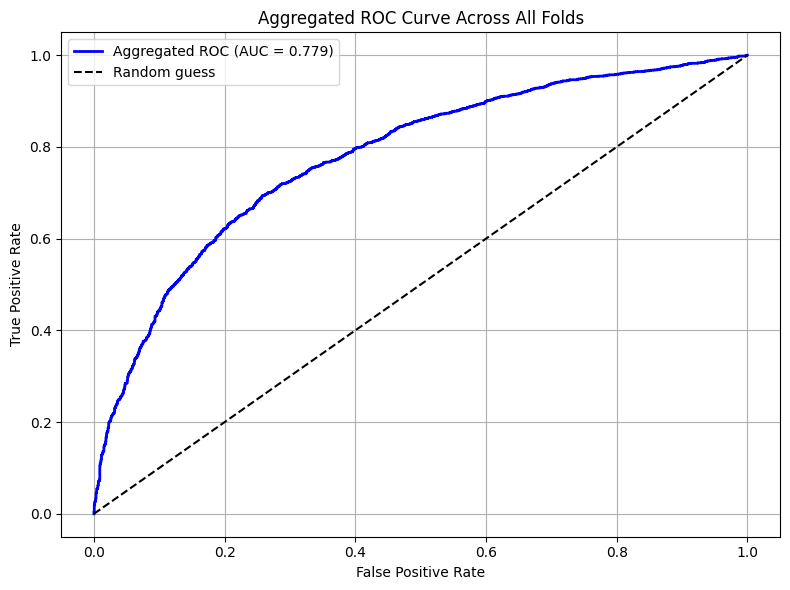

F1-SCORE (Class 0.0): 0.6582 ± 0.0059
F1-SCORE (Class 1.0): 0.7568 ± 0.0055
F1-SCORE (Class macro avg): 0.7075 ± 0.0042
Accuracy: 0.7159 ± 0.0044


####### Processing 512D WITH SMOTE #######


@@@@@@@@ Running 5-Fold Cross Validation with external test set @@@@@@@@


--- Fold 1/5 ---



Classification report for fold 1:

              precision    recall  f1-score   support

         0.0       0.61      0.64      0.62       381
         1.0       0.74      0.72      0.73       558

    accuracy                           0.69       939
   macro avg       0.68      0.68      0.68       939
weighted avg       0.69      0.69      0.69       939


--- Fold 2/5 ---



Classification report for fold 2:

              precision    recall  f1-score   support

         0.0       0.64      0.65      0.64       381
         1.0       0.76      0.75      0.75       558

    accuracy                           0.71       939
   macro avg       0.70      0.70      0.70       939
weighted avg       0.71      0.71      0.71       939


--- Fold 3/5 ---



Classification report for fold 3:

              precision    recall  f1-score   support

         0.0       0.66      0.66      0.66       381
         1.0       0.77      0.77      0.77       558

    accuracy                           0.72       939
   macro avg       0.71      0.71      0.71       939
weighted avg       0.72      0.72      0.72       939


--- Fold 4/5 ---



Classification report for fold 4:

              precision    recall  f1-score   support

         0.0       0.65      0.65      0.65       381
         1.0       0.76      0.76      0.76       558

    accuracy                           0.71       939
   macro avg       0.70      0.70      0.70       939
weighted avg       0.71      0.71      0.71       939


--- Fold 5/5 ---



Classification report for fold 5:

              precision    recall  f1-score   support

         0.0       0.64      0.73      0.68       381
         1.0       0.80      0.72      0.76       558

    accuracy                           0.72       939
   macro avg       0.72      0.73      0.72       939
weighted avg       0.73      0.72      0.73       939



 Total training time across 5 folds: 70.57 seconds (0.02 hours)
Approximate GPU usage: 0.02 GPU hours (using 1 GPU(s))


Aggregated metrics across folds:

Class/Average: 0.0
  precision: 0.6384 ± 0.0153
  recall: 0.6651 ± 0.0340
  f1-score: 0.6511 ± 0.0194
  support: 381.0000 ± 0.0000

Class/Average: 1.0
  precision: 0.7651 ± 0.0174
  recall: 0.7427 ± 0.0183
  f1-score: 0.7534 ± 0.0107
  support: 558.0000 ± 0.0000

Class/Average: macro avg
  precision: 0.7018 ± 0.0140
  recall: 0.7039 ± 0.0150
  f1-score: 0.7023 ± 0.0139
  support: 939.0000 ± 0.0000

Class/Average: weighted avg
  precision: 0.7137 ± 0.0143
  recall: 0.7112 ± 0.

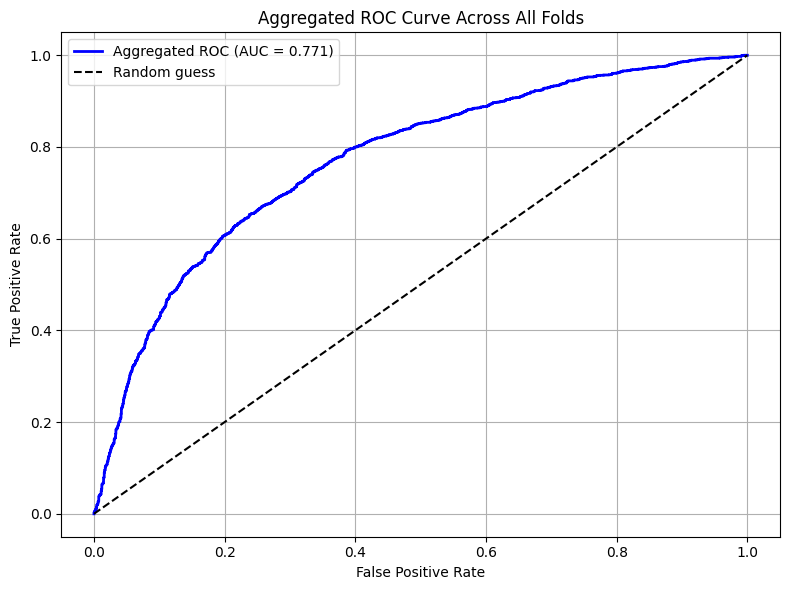

F1-SCORE (Class 0.0): 0.6511 ± 0.0194
F1-SCORE (Class 1.0): 0.7534 ± 0.0107
F1-SCORE (Class macro avg): 0.7023 ± 0.0139
Accuracy: 0.7112 ± 0.0129


In [26]:
# ---- With SMOTE ----
for dim in embedding_dims:
    print(f"\n\n####### Processing {dim}D WITH SMOTE #######\n")
    X = np.array(eval(f"train_embeddings_{dim}"))
    y = np.array(labels_train)
    sm = SMOTE(random_state=dim)
    X_resampled, y_resampled = sm.fit_resample(X, y)
    X_test_ext = np.array(eval(f"test_embeddings_{dim}"))
    y_test_ext = np.array(labels_test)

    reports, (y_true, y_prob), _, train_time = stratified_fold_cv(
        X_resampled, y_resampled, X_test_ext, y_test_ext,
        smote=False,  # Already applied manually
        k=5,
        verbose=False,
        return_fold_roc=True,
        num_gpus=1
    )

    # Save for plotting separately if you want
    all_ytrue_yprob[f"Dim {dim} (SMOTE)"] = (y_true, y_prob)

    # Extract stats
    f1_0 = analyze_results(reports, metric='f1-score', cls=0.0)
    f1_1 = analyze_results(reports, metric='f1-score', cls=1.0)
    macro_f1 = analyze_results(reports, metric='f1-score', cls='macro avg')
    acc = analyze_accuracy(reports)
    auc_val = roc_auc_score(y_true, y_prob)
    
    results_summary.append({
    "Model": f"MLP ({dim}d, SMOTE)",
    "Accuracy": f"{np.mean(acc):.4f} ± {mean_confidence_interval(acc)[1]:.4f}",
    "F1_0": f"{np.mean(f1_0):.4f} ± {mean_confidence_interval(f1_0)[1]:.4f}",
    "F1_1": f"{np.mean(f1_1):.4f} ± {mean_confidence_interval(f1_1)[1]:.4f}",
    "Macro_F1": f"{np.mean(macro_f1):.4f} ± {mean_confidence_interval(macro_f1)[1]:.4f}",
    "ROC_AUC": f"{auc_val:.4f}",
    "Total Time (s)": f"{train_time:.4f}",
    "SMOTE": "Yes"
})



In [27]:
# === Final Table ===
df = pd.DataFrame(results_summary)
df = df[["Model", "Accuracy", "F1_0", "F1_1", "Macro_F1", "ROC_AUC", "Total Time (s)", "SMOTE"]]
print("\n\nFinal Performance Summary Table:\n")
df





Final Performance Summary Table:



,Model,Accuracy,F1_0,F1_1,Macro_F1,ROC_AUC,Total Time (s),SMOTE
0,MLP (50d),0.7152 ± 0.0079,0.6123 ± 0.0092,0.7749 ± 0.0080,0.6936 ± 0.0073,0.7780,57.0483,No
1,MLP (100d),0.7150 ± 0.0039,0.6199 ± 0.0143,0.7718 ± 0.0053,0.6958 ± 0.0062,0.7802,53.2551,No
2,MLP (300d),0.7150 ± 0.0044,0.6182 ± 0.0112,0.7726 ± 0.0038,0.6954 ± 0.0059,0.7707,56.3936,No
3,MLP (512d),0.7110 ± 0.0131,0.6112 ± 0.0253,0.7699 ± 0.0081,0.6905 ± 0.0164,0.7674,60.1603,No
4,"MLP (50d, SMOTE)",0.7250 ± 0.0089,0.6576 ± 0.0130,0.7703 ± 0.0066,0.7139 ± 0.0098,0.7857,68.7984,Yes
5,"MLP (100d, SMOTE)",0.7154 ± 0.0072,0.6495 ± 0.0089,0.7599 ± 0.0133,0.7047 ± 0.0038,0.7815,65.1792,Yes
6,"MLP (300d, SMOTE)",0.7159 ± 0.0044,0.6582 ± 0.0059,0.7568 ± 0.0055,0.7075 ± 0.0042,0.7785,65.9734,Yes
7,"MLP (512d, SMOTE)",0.7112 ± 0.0129,0.6511 ± 0.0194,0.7534 ± 0.0107,0.7023 ± 0.0139,0.7709,70.5682,Yes


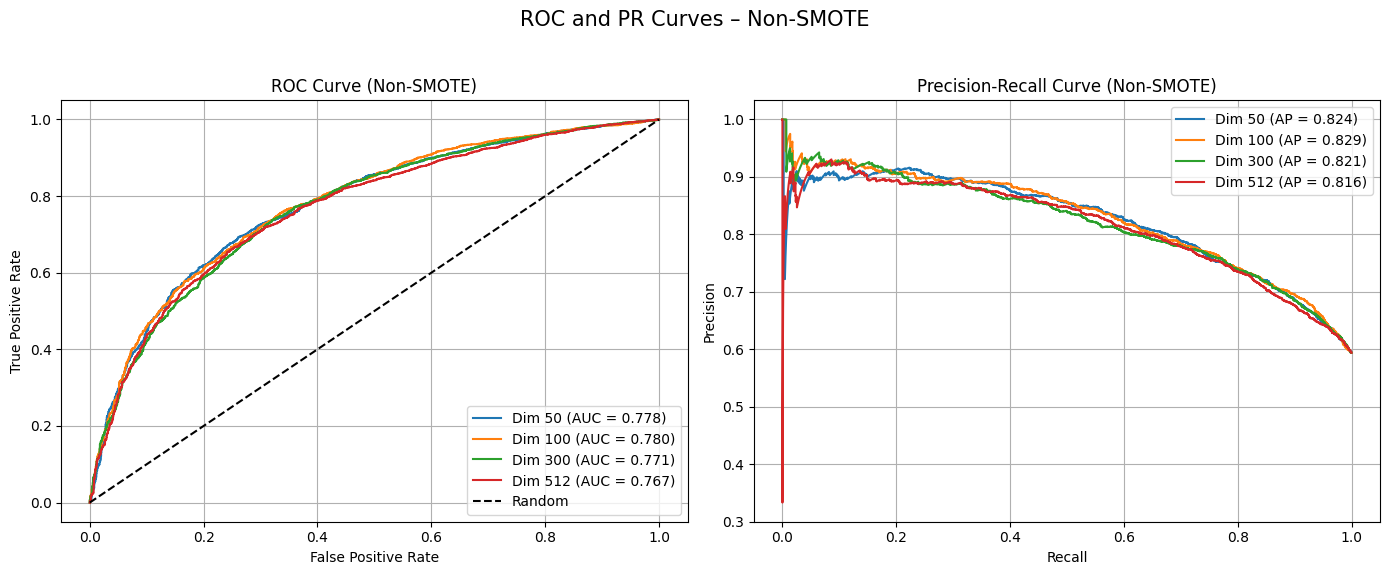

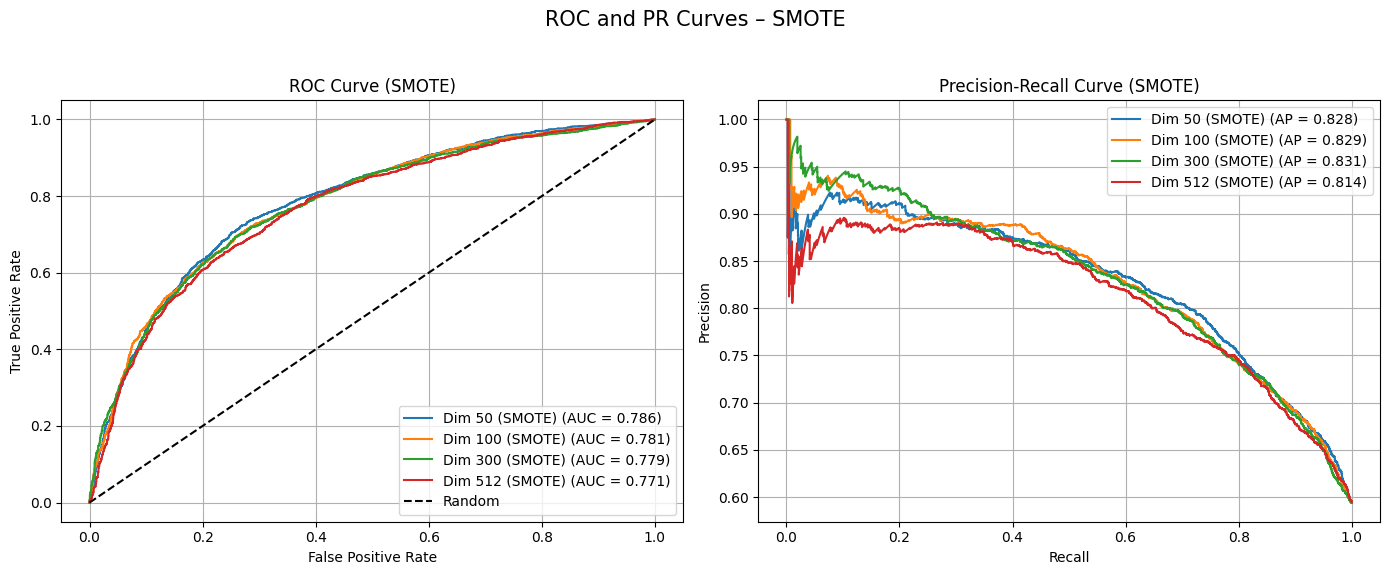

In [28]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


non_smote_dict = {k: v for k, v in all_ytrue_yprob.items() if "SMOTE" not in k}
smote_dict = {k: v for k, v in all_ytrue_yprob.items() if "SMOTE" in k}

# Define the plotting function
def plot_roc_pr_group(data_dict, group_name="Group"):
    fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(14, 6))

    for label, (y_true, y_score) in data_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc_val = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc_val:.3f})')

        precision, recall, _ = precision_recall_curve(y_true, y_score)
        ap_val = average_precision_score(y_true, y_score)
        ax_pr.plot(recall, precision, label=f'{label} (AP = {ap_val:.3f})')

    # ROC plot settings
    ax_roc.plot([0, 1], [0, 1], 'k--', label='Random')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title(f'ROC Curve ({group_name})')
    ax_roc.legend()
    ax_roc.grid(True)

    # PR plot settings
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.set_title(f'Precision-Recall Curve ({group_name})')
    ax_pr.legend()
    ax_pr.grid(True)

    plt.suptitle(f'ROC and PR Curves – {group_name}', fontsize=15)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot both groups
plot_roc_pr_group(non_smote_dict, group_name="Non-SMOTE")
plot_roc_pr_group(smote_dict, group_name="SMOTE")
